# MXNet Numpy
Briefly describe what are we going to talk about


In [1]:
# a bit of setup

import matplotlib.pyplot as plt

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
import numpy as np
import numpy.random as random
import time
from util import get_data, plot_data

# Initialize data and weight

data, label = get_data()
num_samples = data.shape[0]
num_features = data.shape[1]
num_classes = label.shape[1]

weight = random.randn(num_features, num_classes)

print 'Shapes: data {}, label {}, w {}'.format(data.shape, label.shape, weight.shape)
print '# samples: {}'.format(num_samples)
print '# features: {}'.format(num_features)
print '# classes: {}'.format(num_classes)

Shapes: data (10000, 500), label (10000, 5), w (500, 5)
# samples: 10000
# features: 500
# classes: 5


## Logistic regression using Numpy

In [3]:
# predict the class using logistic regression
def predict(w, x):
    a = np.exp(np.dot(x, w))
    a_sum = np.sum(a, axis=1, keepdims=True)
    prob = a / a_sum
    return prob

Ground truth


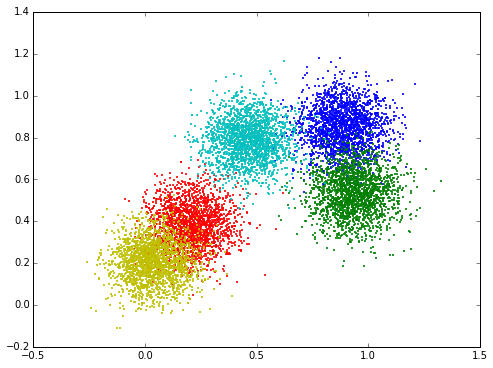

In [4]:
# Visualize what the ground truth data looks like
print 'Ground truth'
plot_data(data, label)

Initial Guess


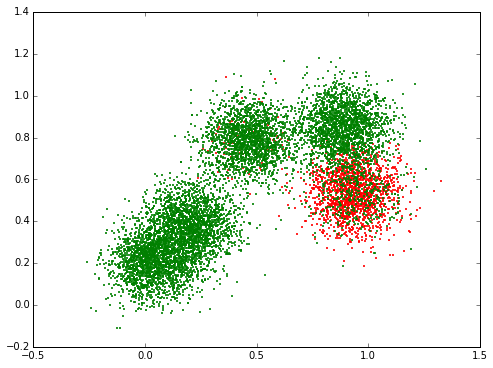

In [5]:
# Visualize the initial guess
print 'Initial Guess'
plot_data(data, predict(weight, data))

In [6]:
# Using gradient descent to fit the correct classes
def train(w, x, loops):
    for i in range(loops):
        prob = predict(w, x)
        if i % 10 == 0:
            print 'Iter {}, training loss {}'.format(i, -np.sum(np.log(prob) * label) / num_samples)
        # calculate gradient of weight
        dy = prob - label
        dw = np.dot(data.T, dy) / num_samples
        w -= 0.1 * dw

# Now training it for 100 iterations
start_time = time.time()
train(weight, data, 100)
print 'Training time: {}s'.format(time.time() - start_time)

Iter 0, training loss 19.0426415926
Iter 10, training loss 0.627487676242
Iter 20, training loss 0.181193996748
Iter 30, training loss 0.0944591594676
Iter 40, training loss 0.061451769769
Iter 50, training loss 0.0447454286565
Iter 60, training loss 0.0348433032396
Iter 70, training loss 0.028356759023
Iter 80, training loss 0.0238057038774
Iter 90, training loss 0.0204494810738
Training time: 8.45637202263s


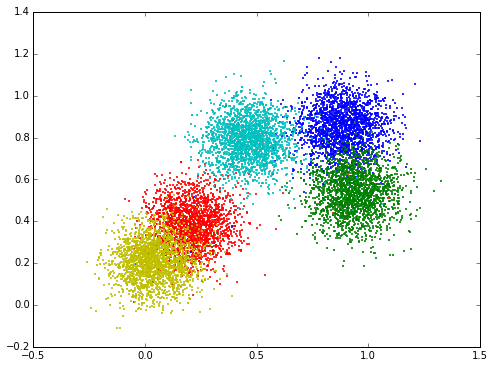

In [7]:
# Plot the prediction after training. It should show similar image as the ground truth.
plot_data(data, predict(weight, data))

## Logistic regression using MXNet Numpy

### Utilize GPU computation with little (or no) numpy syntax change

In [8]:
import minpy.numpy as np
import minpy.numpy.random as random

I[0331 00:53:04 14878 mocking.py:25:__init__] Initialize module: minpy.numpy.random
I[0331 00:53:04 14878 mocking.py:33:__init__] Importing from minpy.array_variants.numpy.random
I[0331 00:53:04 14878 mocking.py:40:__init__] Got 52 primitives from minpy.array_variants.numpy.random
I[0331 00:53:04 14878 mocking.py:33:__init__] Importing from minpy.array_variants.mxnet.random
I[0331 00:53:04 14878 mocking.py:40:__init__] Got 2 primitives from minpy.array_variants.mxnet.random
I[0331 00:53:04 14878 mocking.py:44:__init__] Import 54 primitives
I[0331 00:53:04 14878 mocking.py:25:__init__] Initialize module: minpy.numpy
I[0331 00:53:04 14878 mocking.py:33:__init__] Importing from minpy.array_variants.numpy
I[0331 00:53:04 14878 mocking.py:40:__init__] Got 388 primitives from minpy.array_variants.numpy
I[0331 00:53:04 14878 mocking.py:33:__init__] Importing from minpy.array_variants.mxnet
I[0331 00:53:04 14878 mocking.py:40:__init__] Got 21 primitives from minpy.array_variants.mxnet
I[0331 0

In [9]:
# Initialize weight matrix (again)
weight = random.randn(num_features, num_classes)

# Now training it for 100 iterations
start_time = time.time()
train(weight, data, 100)
print 'Training time: {}s'.format(time.time() - start_time)

Iter 0, training loss 22.9408734375
Iter 10, training loss 2.92371640625
Iter 20, training loss 0.4092234375
Iter 30, training loss 0.161319592285
Iter 40, training loss 0.093051739502
Iter 50, training loss 0.0633317687988
Iter 60, training loss 0.0471960968018
Iter 70, training loss 0.0372283508301
Iter 80, training loss 0.0305287872314
Iter 90, training loss 0.0257500823975
Training time: 3.29381799698s


### Automatic gradient calculation

In [ ]:
from minpy.core import grad

# Initialize weight matrix (again)
weight = random.randn(num_features, num_classes)

# Using gradient descent to fit the correct classes
def train_loss(w, x):
    prob = predict(w, x)
    return -np.sum(np.log(prob) * label) / num_samples

# Calculate gradient function automatically
grad_function = grad(train_loss)

# Now training it for 100 iterations
start_time = time.time()
for i in range(100):
    dw = grad_function(weight, data)
    weight -= 0.1 * dw
print 'Training time: {}s'.format(time.time() - start_time)